<a href="https://colab.research.google.com/github/upperai0510/project_team/blob/sejin/DACON/%5BDACON%5D_Vision_training_competition_with_Argument.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dacon.io/competitions/official/235697/overview/

In [ ]:
from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/스터디/DACON/2차 배포.zip" "data_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2.zip"

In [ ]:
from google.colab import output
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
!mkdir "./dirty_mnist"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist/"
# 출력 결과 지우기
output.clear()

In [ ]:
! nvidia-smi

In [ ]:
! pip install torchinfo
! pip install efficientnet_pytorch

ERROR: Operation cancelled by user
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=1f8a2d2a682317c79dd285be92c992f0c72faf37db822621005cdcc8f252132b
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
import os
from typing import Tuple, Sequence, Callable
import csv
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
import torch.optim as optim
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary

from torchvision import transforms
from torchvision.models import resnet152
from torchvision.models import resnet101
from torchvision.models import resnet50
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')


ModuleNotFoundError: ignored

In [ ]:
class MnistDataset(Dataset):
    def __init__(
        self,
        dir: os.PathLike,
        image_ids: os.PathLike,
        transforms: Sequence[Callable]
    ) -> None:
        self.dir = dir
        self.transforms = transforms

        self.labels = {}
        with open(image_ids, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                self.labels[int(row[0])] = list(map(int, row[1:]))

        self.image_ids = list(self.labels.keys())

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int) -> Tuple[Tensor]:
        image_id = self.image_ids[index]
        image = Image.open(
            os.path.join(
                self.dir, f'{str(image_id).zfill(5)}.png')).convert('RGB')
        target = np.array(self.labels.get(image_id)).astype(np.float32)

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target

In [ ]:
# 이미지 변형하기 Data Argument

transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 이미지를 랜덤으로 수평으로 뒤집는다
    transforms.RandomVerticalFlip(p=0.5),   # 이미지를 랜덤으로 수직으로 뒤집는다
    transforms.ToTensor(),                  # 이미지 데이터를 tensor로 바꿔준다
    transforms.Normalize(                   # 이미지를 정규화한다.
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [ ]:
trainset = MnistDataset('/content/dirty_mnist', '/content/dirty_mnist_2nd_answer.csv', transforms_train)
testset = MnistDataset('/content/test_dirty_mnist', '/content/sample_submission.csv', transforms_test)

m=len(trainset)
train_data, val_data = random_split(trainset, [int(m-m*0.2), int(m*0.2)])

train_loader = DataLoader(train_data, batch_size=64, num_workers=0, drop_last=True)
valid_loader = DataLoader(val_data, batch_size=16, num_workers=0, drop_last=True)
test_loader = DataLoader(testset, batch_size=16, num_workers=0, drop_last=True)

In [ ]:
class MnistModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet101(pretrained=True)
        self.classifier = nn.Linear(1000, 26)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MnistModel().to(device)
print(summary(model, input_size=(1, 3, 256, 256), verbose=0))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MultiLabelSoftMarginLoss()

num_epochs = 30
valid_acc_max = 0
for epoch in range(num_epochs):
  model.train()
  for i, (images, targets) in enumerate(train_loader):
      optimizer.zero_grad()

      images = images.to(device)
      targets = targets.to(device)

      outputs = model(images)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

  outputs = outputs > 0.5
  acc = (outputs == targets).float().mean()
  print(f'{epoch} Train : loss_{loss.item():.5f}, acc_{acc.item():.5f}', end =" / ")

  model.eval()
  for idx, (images, targets) in enumerate(valid_loader):

      images = images.to(device)
      targets = targets.to(device)

      with torch.no_grad():
        outputs = model(images)
        loss = criterion(outputs, targets)

  outputs = outputs > 0.5
  val_acc = (outputs == targets).float().mean()

  if valid_acc_max < val_acc:
    best_model = model
    best_model_epoch = epoch
    valid_acc_max = val_acc

  print(f'Valid : loss_{loss.item():.5f}, acc_{val_acc.item():.5f}')

path = "/content/drive/MyDrive/스터디/DACON/"
torch.save(best_model, f'{path}{best_model_epoch}_acc_{valid_acc_max.item():.5f}.pth')
torch.save(best_model.state_dict(), f'{path}_weight_{best_model_epoch}_acc_{valid_acc_max.item():.5f}.pth')

* DACON submit : 

1. resnet 101 - 30epoch - 0.8074 (overfitiing)

0 Train : loss_0.68684, acc_0.53666 / Valid : loss_0.68724, acc_0.55048
1 Train : loss_0.67424, acc_0.55829 / Valid : loss_0.72526, acc_0.52163
2 Train : loss_0.65668, acc_0.58293 / Valid : loss_0.65585, acc_0.56971
3 Train : loss_0.63766, acc_0.60156 / Valid : loss_0.65104, acc_0.59856
4 Train : loss_0.61065, acc_0.63281 / Valid : loss_0.65922, acc_0.59615
5 Train : loss_0.58434, acc_0.65805 / Valid : loss_0.65278, acc_0.60337
6 Train : loss_0.56101, acc_0.68990 / Valid : loss_0.89083, acc_0.63221
7 Train : loss_0.51387, acc_0.72055 / Valid : loss_0.56604, acc_0.68510
8 Train : loss_0.49989, acc_0.73077 / Valid : loss_0.54583, acc_0.73558
9 Train : loss_0.47011, acc_0.75601 / Valid : loss_0.50237, acc_0.73558
10 Train : loss_0.43341, acc_0.78125 / Valid : loss_0.49979, acc_0.75481
11 Train : loss_0.40558, acc_0.80349 / Valid : loss_0.45310, acc_0.80048
12 Train : loss_0.39432, acc_0.81370 / Valid : loss_0.43310, acc_0.80288
13 Train : loss_0.37135, acc_0.82332 / Valid : loss_0.40764, acc_0.82212
14 Train : loss_0.33798, acc_0.84976 / Valid : loss_0.39079, acc_0.84375
15 Train : loss_0.31873, acc_0.85577 / Valid : loss_0.39854, acc_0.83413
16 Train : loss_0.30895, acc_0.85337 / Valid : loss_0.40077, acc_0.82452
17 Train : loss_0.29550, acc_0.87139 / Valid : loss_0.39045, acc_0.82452
18 Train : loss_0.27624, acc_0.88582 / Valid : loss_0.38557, acc_0.83894
19 Train : loss_0.25766, acc_0.88582 / Valid : loss_0.36999, acc_0.84856
20 Train : loss_0.25443, acc_0.88822 / Valid : loss_0.39586, acc_0.85096
21 Train : loss_0.24340, acc_0.89663 / Valid : loss_0.36735, acc_0.86538
22 Train : loss_0.21754, acc_0.90565 / Valid : loss_0.37521, acc_0.84856
23 Train : loss_0.19395, acc_0.91707 / Valid : loss_0.41160, acc_0.83654
24 Train : loss_0.19607, acc_0.92007 / Valid : loss_0.38433, acc_0.85817
25 Train : loss_0.17828, acc_0.92668 / Valid : loss_0.37020, acc_0.88462
26 Train : loss_0.16715, acc_0.93630 / Valid : loss_0.44425, acc_0.84856
27 Train : loss_0.14795, acc_0.93990 / Valid : loss_0.43556, acc_0.85337
28 Train : loss_0.14428, acc_0.93990 / Valid : loss_0.44613, acc_0.86779
29 Train : loss_0.13022, acc_0.94952 / Valid : loss_0.48286, acc_0.85817

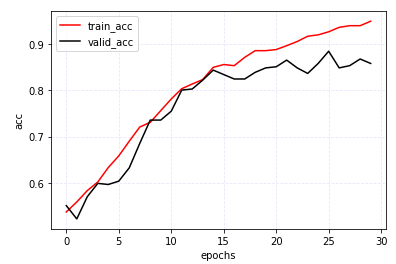

In [ ]:
model = torch.load('/content/drive/MyDrive/스터디/DACON/resnet101_0.93990.pth')

In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')

model.eval()
batch_size = test_loader.batch_size
batch_index = 0
for i, (images, targets) in enumerate(test_loader):
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    outputs = outputs > 0.5
    batch_index = i * batch_size
    submit.iloc[batch_index:batch_index+batch_size, 1:] = \
        outputs.long().squeeze(0).detach().cpu().numpy()
    
submit.to_csv('/content/drive/MyDrive/스터디/DACON/submit_resnet101_3nd.csv', index=False)

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/스터디/DACON/resnet101_final_state_dict.pth')

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib

# history = {'train_acc': [0.53666,	0.55829,	0.58293,	0.60156,	0.63281,	0.65805,	0.6899,	0.72055,	0.73077,	0.75601,	0.78125,	0.80349,	0.8137,	0.82332,	0.84976,	0.85577,	0.85337,	0.87139,	0.88582,	0.88582,	0.88822,	0.89663,	0.90565,	0.91707,	0.92007,	0.92668,	0.9363,	0.9399,	0.9399,	0.94952],
#             'valid_acc': [0.55048,	0.52163,	0.56971,	0.59856,	0.59615,	0.60337,	0.63221,	0.6851,	0.73558,	0.73558,	0.75481,	0.80048,	0.80288,	0.82212,	0.84375,	0.83413,	0.82452,	0.82452,	0.83894,	0.84856,	0.85096,	0.86538,	0.84856,	0.83654,	0.85817,	0.88462,	0.84856,	0.85337,	0.86779,	0.85817]}


# # 도화지 생성
# fig = plt.figure()
# # 정확도 그래프 그리기
# plt.plot(range(30), history['train_acc'], label='train_acc', color='red')
# plt.plot(range(30), history['valid_acc'], label='valid_acc', color='black')
# # 축 이름
# plt.legend()
# plt.xlabel('epochs')
# plt.ylabel('acc')
# plt.grid(linestyle='--', color='lavender')
# # 그래프 표시
# plt.show()
# # 그래프 저장
# plt.savefig('mnist_tensorflow_acc.png')